# Non-Uniform Electric Field GIC Analysis

This notebook demonstrates the complete workflow for computing
geomagnetically induced currents (GICs) under **spatially varying**
electric fields. Unlike a uniform storm analysis, non-uniform fields
capture realistic conductivity gradients, coastal effects, and
geologic heterogeneities.

**Key steps:**

1. Build the GIC model from a PowerWorld case
2. Construct a geographic E-field grid using `Grid2D`
3. Define a non-uniform E-field pattern (Gaussian hotspot)
4. Build the line integration operator $L$ and compute $|\mathbf{I}| = |H \, L \, \mathbf{E}|$
5. Visualize transformer GIC distribution
6. Map bus-level GIC magnitudes as a geographic heatmap
7. Export E-fields to B3D format for PowerWorld integration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from esapp import GridWorkBench
from esapp.components import Branch, Bus, GICXFormer
from esapp.utils import B3D

from examples.mesh import Grid2D
from examples.map import format_plot, border, plot_lines
from examples.nonuniform.nonuniform import build_L_matrix, stack_efield, compute_gic, bus_gic
from examples.nonuniform.plotting import plot_efield, plot_gic_heatmap

In [36]:
# This cell is hidden in the documentation.
import ast

with open('../data/case_B.txt', 'r') as f:
    case_path = ast.literal_eval(f.read().strip())

wb = GridWorkBench(case_path)
SHAPE = 'Texas'

'open' took: 9.7471 sec


In [37]:
# Plotting style constants (hidden from documentation)
_C1 = '#4C72B0'
_C2 = '#DD8452'
_C3 = '#55A868'
_C4 = '#C44E52'
_C5 = '#8172B3'
_CG = '#8C8C8C'
_FS = dict(titlesize=11, labelsize=9, ticksize=8)

## 1. Build the GIC Model

The GIC model extracts substation, bus, branch, and transformer data
from the PowerWorld case and computes the **H-matrix** &mdash; the linear
mapping from induced branch voltages to transformer neutral currents.

In [38]:
wb.gic.configure(pf_include=True, calc_mode='SnapShot')
wb.gic.model()

print(f"H-matrix:  {wb.gic.H.shape}  (transformers x branches)")
print(f"G-matrix:  {wb.gic.G.shape}  (nodes x nodes)")
print(f"Incidence: {wb.gic.A.shape}  (branches x nodes)")

H-matrix:  (861, 4137)  (transformers x branches)
G-matrix:  (3250, 3250)  (nodes x nodes)
Incidence: (4137, 3250)  (branches x nodes)


## 2. Geographic Grid & Network Footprint

We extract bus coordinates from the case and build a structured 2D grid
covering the network footprint. The `Grid2D` class from `examples.mesh`
provides the grid structure and discrete operators.

In [39]:
lon, lat = wb.buscoords()

pad = 0.5
lon_min, lon_max = lon.min() - pad, lon.max() + pad
lat_min, lat_max = lat.min() - pad, lat.max() + pad

nx, ny = 50, 35
lons = np.linspace(lon_min, lon_max, nx)
lats = np.linspace(lat_min, lat_max, ny)
LON, LAT = np.meshgrid(lons, lats)

grid = Grid2D((nx, ny))
print(f"Grid: {nx} x {ny} = {grid.size} points")
print(f"Edges: {grid.n_edges} (H: {grid.n_edges_x}, V: {grid.n_edges_y})")

Grid: 50 x 35 = 1750 points
Edges: 3415 (H: 1715, V: 1700)


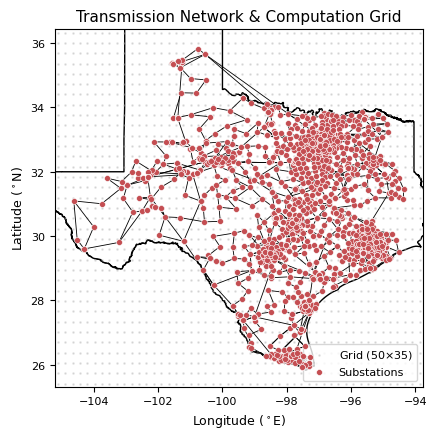

In [40]:
lines = wb[Branch, ['Longitude', 'Longitude:1', 'Latitude', 'Latitude:1']]

fig, ax = plt.subplots(figsize=(6.5, 4.5))
border(ax, SHAPE)
plot_lines(ax, lines, ms=6, lw=0.6)
ax.scatter(LON.ravel(), LAT.ravel(), s=0.8, c='#aaaaaa', alpha=0.3,
           label=f'Grid ({nx}$\\times${ny})', zorder=1)
ax.scatter(lon, lat, s=18, c=_C4, zorder=6, edgecolors='white',
           linewidth=0.4, label='Substations')
ax.set_xlim(lon_min - 0.1, lon_max + 0.1)
ax.set_ylim(lat_min - 0.1, lat_max + 0.1)
format_plot(ax, title='Transmission Network & Computation Grid',
            xlabel=r'Longitude ($^\circ$E)',
            ylabel=r'Latitude ($^\circ$N)',
            plotarea='white', grid=False, **_FS)
ax.legend(fontsize=8, loc='lower right')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 3. Non-Uniform Electric Field Pattern

We define a spatially varying E-field with a **Gaussian hotspot** to
model a localized conductivity anomaly (e.g., a geological boundary
or coastal effect).

In [ ]:
# Normalize geographic coordinates to [0, 1]
Xn = (LON - lon_min) / (lon_max - lon_min)
Yn = (LAT - lat_min) / (lat_max - lat_min)

# Gaussian hotspot E-field
cx, cy = 0.4, 0.5  # hotspot center (normalized)
sigma = 0.15
gauss = 2.5 * np.exp(-((Xn - cx)**2 + (Yn - cy)**2) / (2 * sigma**2))
Ex_field = (0.3 + gauss) * np.sin(np.radians(90))
Ey_field = (0.3 + gauss) * np.cos(np.radians(90))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

im = plot_efield(ax, lons, lats, Ex_field, Ey_field,
                 shape=SHAPE, lines=lines,
                 cmap='viridis', title='Gaussian Hotspot E-Field')

fig.colorbar(im, ax=ax, label='|E| (V/km)', shrink=0.7, pad=0.02)
plt.tight_layout()
plt.show()

## 4. Computing GICs from a Non-Uniform Field

For a uniform storm, PowerWorld's `storm()` method suffices. For a
non-uniform field, we construct a **line integration operator** $L$
that maps a gridded electric field to branch induced voltages.

### The line integral

The EMF voltage induced on branch $k$ connecting buses $a$ and $b$ is
the line integral of the electric field along the conductor path:

$$V_k = \int_a^b \mathbf{E} \cdot d\boldsymbol{\ell}$$

We approximate each transmission line as a **straight segment** from
$(\lambda_a, \phi_a)$ to $(\lambda_b, \phi_b)$ (longitude, latitude).

### Cell-by-cell discretization

The E-field is known at the nodes of a regular $(n_x \times n_y)$ grid.
Rather than evaluate $\mathbf{E}$ at a single point, we **trace** the
line through every grid cell it intersects and accumulate contributions
cell by cell.

For each cell $c = (i, j)$ that branch $k$ passes through, we compute
the **directed segment** $(\Delta x_{kc},\, \Delta y_{kc})$ &mdash;
the signed length of the line within that cell in km:

$$\Delta x_{kc} = \delta\!f_{x}\;\Delta\lambda\;(111\;\text{km/°})\;\cos\bar\phi_k,
\qquad
\Delta y_{kc} = \delta\!f_{y}\;\Delta\phi\;(111\;\text{km/°})$$

where $\delta\!f_x$ and $\delta\!f_y$ are the directed lengths in
**grid-coordinate units** (fractional cells) obtained by intersecting
the segment with the cell boundaries.

The E-field inside cell $(i, j)$ is approximated as the **average of
its four corner nodes**:

$$\bar{E}_x^{(c)} = \tfrac{1}{4}\bigl(
E_x^{(i,j)} + E_x^{(i{+}1,j)} + E_x^{(i,j{+}1)} + E_x^{(i{+}1,j{+}1)}
\bigr)$$

so the voltage contribution from cell $c$ is:

$$\delta V_{kc} = \bar{E}_x^{(c)}\,\Delta x_{kc}
               + \bar{E}_y^{(c)}\,\Delta y_{kc}$$

### The $L$ operator

We stack the gridded field into a single master vector
$\mathbf{E} \in \mathbb{R}^{2N}$ ($N = n_x n_y$):

$$\mathbf{E} = \bigl[\,E_x^{(1)},\ldots,E_x^{(N)},\;
                       E_y^{(1)},\ldots,E_y^{(N)}\,\bigr]^T$$

For each cell $(i,j)$ that branch $k$ traverses, we place weight
$\tfrac{1}{4}\,\Delta x_{kc}$ at each of the four corner-node columns
in the $E_x$ block, and $\tfrac{1}{4}\,\Delta y_{kc}$ in the $E_y$
block. When a branch passes through multiple cells, the COO $\to$ CSR
conversion automatically sums contributions at shared corner nodes.

The full branch voltage is:

$$V_k = (L\,\mathbf{E})_k
      = \sum_{c \in \text{cells}(k)}
        \bigl[\bar E_x^{(c)}\,\Delta x_{kc}
            + \bar E_y^{(c)}\,\Delta y_{kc}\bigr]$$

and the transformer GICs follow as:

$$\mathbf{I}_{\text{GIC}} = \lvert\, H \, L \, \mathbf{E} \,\rvert$$

In [43]:
# Build the line integration operator (computed once for a given grid)
H = wb.gic.H
n_branches_model = H.shape[1]
N_grid = len(lons) * len(lats)

L = build_L_matrix(wb, lons, lats, n_branches_model)
print(f"H-matrix:  {H.shape}  (transformers x branches)")
print(f"L-matrix:  {L.shape}  (branches x 2·grid),  nnz = {L.nnz}")

H-matrix:  (861, 4137)  (transformers x branches)
L-matrix:  (4137, 3500)  (branches x 2·grid),  nnz = 27796


In [ ]:
# Compute transformer GICs:  |I| = |H @ L @ E|
gic_xf = compute_gic(H, L, Ex_field, Ey_field)

# Aggregate to bus-level totals for geographic plotting
gic_bus = bus_gic(wb, gic_xf)

print(f"Transformer GICs computed: {len(gic_xf)}")
print(f"Max |GIC| (transformer): {gic_xf.max():.2f} A")
print(f"Mean |GIC| (transformer): {gic_xf.mean():.2f} A")
print(f"\nBuses with GIC: {len(gic_bus)}")
print(f"Max |GIC| (bus): {gic_bus['GIC'].max():.2f} A")

## 5. Transformer GIC Distribution

The absolute GIC magnitudes $|\mathbf{I}|$ are always non-negative.
We visualize the ranked magnitudes and their distribution.

In [ ]:
ranked = np.argsort(gic_xf)[::-1]
top_n = min(30, len(ranked))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: top transformers by |GIC| magnitude
axes[0].barh(range(top_n), gic_xf[ranked[:top_n]], color='#DD8452')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([f'XF {i}' for i in ranked[:top_n]], fontsize=7)
axes[0].invert_yaxis()
format_plot(axes[0], title=f'Top {top_n} Transformer |GIC|',
            xlabel='|GIC| (A)', plotarea='white', **_FS)

# Right: histogram of |GIC|
axes[1].hist(gic_xf, bins=30, color='#4C72B0', edgecolor='white')
format_plot(axes[1], title='|GIC| Distribution',
            xlabel='|GIC| (A)', ylabel='Count', plotarea='white', **_FS)

plt.tight_layout()
plt.show()

## 6. Geographic GIC Heatmap

Transformer GICs are aggregated to bus-level totals using ``bus_gic()``
and interpolated onto the computation grid to produce a continuous
heatmap of GIC magnitude across the network footprint.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 9))

im = plot_gic_heatmap(ax, lons, lats, gic_bus,
                       shape=SHAPE, lines=lines,
                       cmap='YlOrRd',
                       title='Bus-Level |GIC| Heatmap (Gaussian Hotspot)')

fig.colorbar(im, ax=ax, label='|GIC| (A)', shrink=0.7, pad=0.02)
plt.tight_layout()
plt.show()

## 7. Export to B3D Format

The non-uniform E-field can be exported to PowerWorld's B3D format
for time-varying GIC simulation. `B3D.from_mesh()` converts a gridded
field to the binary format.

In [ ]:
b3d = B3D.from_mesh(
    lons, lats,
    Ex_field.astype(np.float32),
    Ey_field.astype(np.float32),
    comment='Gaussian hotspot E-field'
)

print(f"B3D grid: {b3d.grid_dim}")
print(f"Locations: {len(b3d.lat)}")
print(f"Time steps: {len(b3d.time)}")

## Summary

This notebook demonstrated the full non-uniform GIC analysis workflow:

- **GIC model** construction via `wb.gic.model()` produces the H-matrix
  that linearly maps branch voltages to transformer neutral currents
- The **line integration operator** $L$ traces each transmission line
  through the E-field grid cell by cell, accumulating directed segment
  lengths to discretize the line integral $V_k = \int \mathbf{E} \cdot d\boldsymbol{\ell}$
- Stacking the gridded field as $\mathbf{E} = [E_x, E_y]^T$ enables
  the clean matrix formulation $|\mathbf{I}| = |H \, L \, \mathbf{E}|$
- ``bus_gic()`` aggregates transformer-level GICs to bus-level totals
  for geographic plotting at known bus coordinates
- ``plot_gic_heatmap()`` interpolates sparse bus GICs onto the
  computation grid for a continuous geographic heatmap
- Export to **B3D format** enables PowerWorld integration for
  time-varying non-uniform GIC simulations